In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import copy
def activation(x):
    return 1 / (1 + np.exp(-x))
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

class MLP:
    
    
    def __init__(self, *args):
       
        np.random.seed(123)
      
        self.shape = args
        n = len(args)
       
        self.layers = []
       
        self.layers.append(np.ones(self.shape[0]+1))
     
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        self.dw = [0,]*len(self.weights)

        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):

            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))

            self.weights[i][...] = (2*Z-1)*1

    
    def propagate_forward(self, data):
        
        self.layers[0][0:-1] = data
       
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
       
        return self.layers[-1]


    
     #HF2 start l1reg, l2reg, momentum  
    def propagate_backward(self, target, lrate=0.1,  lmbda1=0.000005, lmbda2=0.000005, mom_coef = 0.05) :
        deltas = []
       
        error = -(target-self.layers[-1]) # y-y_hat
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        
        for i in range(len(self.shape)-2,0,-1):
           
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
   
        for i in range(len(self.weights)):
            
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])

            dw = -lrate*np.dot(layer.T,delta)

            #up until this point I did not change anything (other than the function parameters)
            if(mom_coef != 0 ):                   #in case we use momentum
             self.dw[i] = dw+mom_coef*self.dw[i]  #the formula for calculating the new delta w: we multiply the old dw by the momentum coefficient and add it to the old dw  
            else:
              self.dw[i] = dw                     #if we do not use momentum, then its just dw 

            if(mom_coef != 0):
              self.weights[i] += self.dw[i]       #in case we use momentum, the new weight is the previously calculated value + the old weight
            else:
              self.weights[i] += dw-lrate*lmbda1*np.sign(self.weights[i])-lrate*lmbda2*self.weights[i]   #i used a formula for both the l1reg and l2reg
                                                                                                         #in case l1reg or l2reg is 0, the multiplication equals to 0 (hence nonexistent)

            sum = 0 
            if(lmbda1!=0):                          #in case we use l1reg, we have to count the sum of the absolute values of the weights 
              for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                  sum += abs(self.weights[i][j])
            elif(lmbda2 != 0):                      #in case we use l2reg, we sum together the weigh**2 values 
              for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                  sum+=self.weights[i][j]**2

            
            if(lmbda1 != 0 ):  
              lmbda = lmbda1        #if lmbda1 is not zero (meaning that we use L1 reg.) then we need the multiplier(or at least that's what i was taught)
            elif(lmbda2 != 0): 
              lmbda=lmbda2*0.5
            else:
              lmbda=0

        # return the loss 

        return ((error**2).sum() + lmbda*sum)   # (error**2).sum() is the "old" cost function, lmbda*sum is the regularization term(depending on whether we use l1 or l2)

        #HF2 end l1reg, l2reg, momentum 
        #I've added some parameters to the function below as well, but those are of little importance 
      

In [ ]:
def learn(network, X, Y, valid_split=0.2, test_split=0.1, epochs=20, lrate=0.1, lmbda1=0.000005, lmbda2=0.000005, mom_coef=0.05):
  v_start = int(nb_samples*(1-valid_split-test_split))
  t_start = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:v_start],        Y[:v_start]
  X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
  X_test , Y_test  = X[t_start:],        Y[t_start:]

  randperm = np.random.permutation(len(X_train))
  X_train, Y_train = X_train[randperm], Y_train[randperm]

  for i in range(epochs):
   
    train_err = 0
    for k in range(X_train.shape[0]):
       
        neural_net.propagate_forward(X_train[k])
       
        sample_err = neural_net.propagate_backward( Y_train[k], lrate, lmbda1, lmbda2, mom_coef)
        train_err += sample_err
  
    train_err /= X_train.shape[0]
  
    valid_err = 0
    o_valid = np.zeros(X_valid.shape[0])
    for k in range(X_valid.shape[0]):
     
      o_valid[k] = neural_net.propagate_forward(X_valid[k])
    
      sample_err = (Y_valid[k]-o_valid[k])**2
      valid_err += sample_err
    valid_err /= X_valid.shape[0]
    
    print("{}. epoch\ttrain error: {}\tvalid error: {}".format(i,np.round(train_err,3),np.round(valid_err,3)))


  test_err = 0
  o_test = np.zeros(X_test.shape[0])
  for k in range(X_test.shape[0]):

    o_test[k] = neural_net.propagate_forward(X_test[k])

    sample_err = (Y_test[k]-o_test[k])**2
    test_err += sample_err
    print("True value: {}\tPredicted value: {}\tInput:{},{}".format(Y_test[k],o_test[k],X_test[k,0],X_test[k,1]))
  test_err /= X_test.shape[0]
  print("Test error: {}".format(test_err))

  fig1=plt.figure()
  plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]))


0. epoch	train error: 0.251	valid error: 0.248
1. epoch	train error: 0.246	valid error: 0.239
2. epoch	train error: 0.22	valid error: 0.192
3. epoch	train error: 0.156	valid error: 0.131
4. epoch	train error: 0.108	valid error: 0.1
5. epoch	train error: 0.085	valid error: 0.085
6. epoch	train error: 0.073	valid error: 0.077
7. epoch	train error: 0.066	valid error: 0.072
8. epoch	train error: 0.062	valid error: 0.068
9. epoch	train error: 0.058	valid error: 0.066
10. epoch	train error: 0.056	valid error: 0.064
11. epoch	train error: 0.054	valid error: 0.063
12. epoch	train error: 0.052	valid error: 0.062
13. epoch	train error: 0.051	valid error: 0.061
14. epoch	train error: 0.05	valid error: 0.06
15. epoch	train error: 0.049	valid error: 0.06
16. epoch	train error: 0.048	valid error: 0.059
17. epoch	train error: 0.048	valid error: 0.059
18. epoch	train error: 0.047	valid error: 0.058
19. epoch	train error: 0.047	valid error: 0.058
20. epoch	train error: 0.047	valid error: 0.058
21. epoc

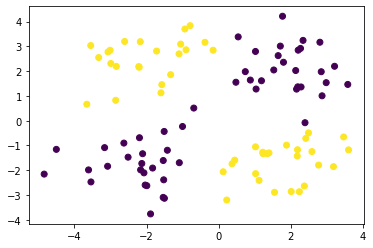

In [ ]:
neural_net.reset()
np.random.seed(100)
neural_net = MLP(2,3,1)
learn(neural_net, X, Y, epochs=150, lrate=0.1, lmbda1 = 0, lmbda2=0, mom_coef=0.5)